# CMSC 320 FINAL PROJECT: WHAT COUNTRY HAS THE GREATEST NATIONAL FOOTBALL(SOCCER)?
Owners: Nathaniel Bekele and Mikias Atnafu

## Introduction:
First and foremost, we will be establishing what we believe to be the most important boundary for this project, we will be referring to the sport exclusively as football not soccer.

### Datasets used:
For this project we have used two datasets.
1. The first is a compilation of International Football results from 1872 to 2017 that includes various tournaments and even friendly matches played by National Teams. It was compiled by Mart Jürisoo and is available on [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?resource=download).
2. The second is a compilation of FIFA World Cup data from 1930 to 2018 that has the matches played, the champions, host country etc for every single world cup. It was compiled by Sourav Banerjee and is also available on [Kaggle](https://www.kaggle.com/datasets/iamsouravbanerjee/fifa-football-world-cup-dataset?select=FIFA+-+World+Cup+Summary.csv.)

## Factors to be considered:
### Time period
This dataset has all the results of international football fixtures from 1872 to 2022. While it would be amazing to consider the data from 1872, we also thought of the possibility that it would be rather unfair on most countries that were colonized at the time and hence did not have a national team to compete with. Thus we will be limiting the data to 1976 to 2022 
### Attacking capabilities
We will be considering the attacking capabilities of the teams. This is a very important factor to consider as goals win games for the most part, great attacking play is often the deciding factor in a game.
### Defensive capabilities
We will be considering the defensive capabilities of the teams. This is a very important factor to consider, while goals do win games, you have to score more than you conceed in order to win a game and having great defensive play is what makes this possible.
### Trophies won, finals played
We will be considering the number of trophies won and finals played by the teams. This shows the strength of a team to play all the way through the tournament and win it, often times this shows who the best team is at that tournament.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
sns.set_theme()

# Data Preprocessing
Before we start our analysis deciding what country has the greatest national football team, we need to preprocess and clean up the data. So, first we read the csv file as pandas dataframe because pandas dataframe makes it easer to manipulate datasets. 

We have used two data sets, The first one is the *international football results*, and the second one is the football *world cup summary*, which will help us to see who reached the final and who won the world cup over the years starting from 1930 to 2018.    

### Reading in the first dataset, *The international football result*

In [22]:
football_df = pd.read_csv('results.csv')
football_df.head() 

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


### Reading in the second dataset, *World Cup Summary*

In [23]:
# read the FIFA world cup summary and display the first 5 rows 
world_cup_summary = pd.read_csv('FIFA-World Cup Summary.csv')
world_cup_summary.head()

,YEAR,HOST,CHAMPION,RUNNER UP,THIRD PLACE,TEAMS,MATCHES PLAYED,GOALS SCORED,AVG GOALS PER GAME
0,1930,Uruguay,Uruguay,Argentina,United States,13,16,70,3.6
1,1934,Italy,Italy,Czechoslovakia,Germany,16,17,70,4.1
2,1938,France,Italy,Hungary,Brazil,15,18,84,4.7
3,1950,Brazil,Uruguay,Brazil,Sweden,13,22,88,4.0
4,1954,Switzerland,West Germany,Hungary,Austria,16,26,140,5.4


## Filtering the dataset
We need to filter our dataset so that we can have a refined data to work with. As you can see in the first dataframe, which we saved as football_df, the data is formated as (yyyy-mm-dd). However, because we want to filter our dataset and take only the year from 1976 onward, we need to parse the data column and extract only the year and put it in a separate column. Another column we need to clean up is the tournament colmun. <br>
The tournament column contains very many tournaments (177 to be specific), for this project we will only focus on the FIFA World Cup, so we will only be working with the worldcup tournament.<br>

The reason we chose to specifically focus on the world cup is because it is the biggest sports competition on the planet with qualifiers played by teams representing their countries from every single continent, and so unless a country is specifically banned by FIFA from the world cup, every country has a chance to go to the world cup. This makes the world cup the best tournament to take as a metric for best football team.<br>

Also, to make the analysis a bit more convenient, we will add several columns into our dataframe suchas Winning percentage, Number of losses, Number of matches played any a few others. Using these columns, we can better analysis the best national team. 

The first thing we will do is extract the year from the date column. to do that we will use regEx to extract the first four decimals from the data and we change to an integer then store it into a new  column. <br>
Then we will extract the data with years on or after the year 2000. 

In [24]:
# Create column Year using the year in the date column
football_df['year'] = football_df['date'].str.extract('(\d\d\d\d)')

# Change column Year to type int
football_df['year'] = football_df['year'].astype(int)

# filter only the data with year >= 2000 
football_df = football_df[football_df['year'] > 2000]

# filters the dataset by taking the world cup after the year 2000 
world_cup_summary = world_cup_summary[world_cup_summary['YEAR'] > 2000]
football_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
23643,2001-01-04,Kenya,Zambia,2,1,Friendly,Nairobi,Kenya,False,2001
23644,2001-01-06,Costa Rica,Guatemala,5,2,FIFA World Cup qualification,Miami,United States,True,2001
23645,2001-01-06,Egypt,United Arab Emirates,2,1,Friendly,Cairo,Egypt,False,2001
23646,2001-01-06,Eswatini,Angola,1,0,Friendly,Manzini,Eswatini,False,2001
23647,2001-01-07,Angola,Lesotho,2,0,Friendly,Manzini,Eswatini,True,2001


Now that we added a new year column and filter the data based on the year, let refine our dataset furture by takeing only the worldcup tournamaent. Narrowing down the dataset will help us to do the analysis easily, otherwise it will be very difficult to do the analysis. A simple check of the number of unique torunamnets will tell us that there are 116 tornaments. This is why we narrow it down by taking only the world cup   

In [25]:
# Filter only the FIFA World Cup tournment
FIFA_WC = football_df[football_df['tournament'] == 'FIFA World Cup'].copy()
FIFA_WC.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
24966,2002-05-31,France,Senegal,0,1,FIFA World Cup,Seoul,South Korea,True,2002
24967,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,Sapporo,Japan,True,2002
24968,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,Niigata,Japan,True,2002
24969,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,Ulsan,South Korea,True,2002
24970,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,Kashima,Japan,True,2002


In the code below, we are going to group the dataset by the teams and create a column for the goal scored and goal conceeded for each team.
The goal scored column will help us to see which team is good at attacking, whereas the goal conceeded tell us about the teams defense strength. For convenience, we will combine the home_team and away_team so that we will have a new dataframe with only the necessary rows. There are two teams (El Salvador and Kuwait) that are in away_team but not in home team. <br>

**How do we know that?** <br>

We checked the length of the home_team and away_team then saw that home_team was 72 where as away_team was 74. We then printed out to see who those two teams were that played as an away_team but not home_team.(they were El Salvador and Kuwait) therefore, we don't consider this two teams when getting the team information from the home_team.

In [26]:
team_group_home = FIFA_WC.groupby(by='home_team')    # group the data by home_team
team_group_away = FIFA_WC.groupby(by='away_team')    # group the data by away_team

In [27]:
clean_data = {'country':[], 'win_percentage':[], 'match_played':[], 'match_won':[], 'match_lost':[],
              'goal_scored':[], 'goal_conceded':[], 'avg_goal_score_per_match':[]}

# add the team names of the home_team and away_team 
team_name = list(FIFA_WC['home_team'].unique())
team_name.extend(t for t in list(FIFA_WC['away_team'].unique()) if not t in team_name)

# iterate over each team and get the necessary information to create a new dataframe
for current_team in team_name:
    goal_scored = goal_conceded = 0
    
    # El Salvador and Kuwait are not in home_team so skip them 
    if current_team != 'El Salvador' and current_team != 'Kuwait':
        team_home = team_group_home.get_group(current_team)    # a single team from a home_team  
        # number of time won while a home team
        num_won_home = len(team_home[team_home['home_score']  > team_home['away_score']])
        goal_scored = team_home['home_score'].sum() 
        goal_conceded = team_home['away_score'].sum() 
    else: # we found the two teams that are not in home_team
        num_won_home = 0
        team_home = []

    # a single team from an away_team
    team_away = team_group_away.get_group(current_team)         
    # number of time won while an away team
    num_won_away = len(team_away[team_away['away_score']  > team_away['home_score']])
    goal_scored += team_away['away_score'].sum()
    goal_conceded += team_away['home_score'].sum() 

    total_num_won = num_won_home + num_won_away
    total_num_played = len(team_home) + len(team_away)
    win_per =  total_num_won / total_num_played

    # append the row to the dictionary which later be converted to a dataframe
    clean_data['country'].append(current_team)
    clean_data['match_played'].append(total_num_played)
    clean_data['match_won'].append(total_num_won)
    clean_data['match_lost'].append(total_num_played - total_num_won)
    clean_data['win_percentage'].append(win_per)
    clean_data['goal_scored'].append(goal_scored)
    clean_data['goal_conceded'].append(goal_conceded)
    clean_data['avg_goal_score_per_match'].append(goal_scored / total_num_played)


# create a new dataframe using the clean data
tidy_data = pd.DataFrame(clean_data)
tidy_data.head()

,country,win_percentage,match_played,match_won,match_lost,goal_scored,goal_conceded,avg_goal_score_per_match
0,France,0.520000,25,13,12,34,19,1.360000
1,Germany,0.709677,31,22,9,64,22,2.064516
2,Republic of Ireland,0.250000,4,1,3,6,3,1.500000
3,Uruguay,0.473684,19,9,10,26,22,1.368421
4,Argentina,0.583333,24,14,10,37,24,1.541667


# Exploratory Analysis
Now that we have tidied up the data and have what we need to do the analysis, lets do some exploratory analysis. Things become clearer when we visualize them so in this phase, we will visualize some of the columns to see how the team performs overall. 

We can start by doing a barplot of goals scored across the teams. Plotting this will help us to see (visually) who had a higher goal over the total match they played over the years. This allows us to see the attacking strength of each team in the world cup tournaments. <br>

There are many libraries that you can use to do exploratory analysis and data visualization. For this project, we will use matplotlib.pyplot and seaborn. If you would like to read more about them, you can refer to these link, [matplotlib.pyplot](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.html) and [seaborn](https://seaborn.pydata.org/generated/seaborn.barplot.html)


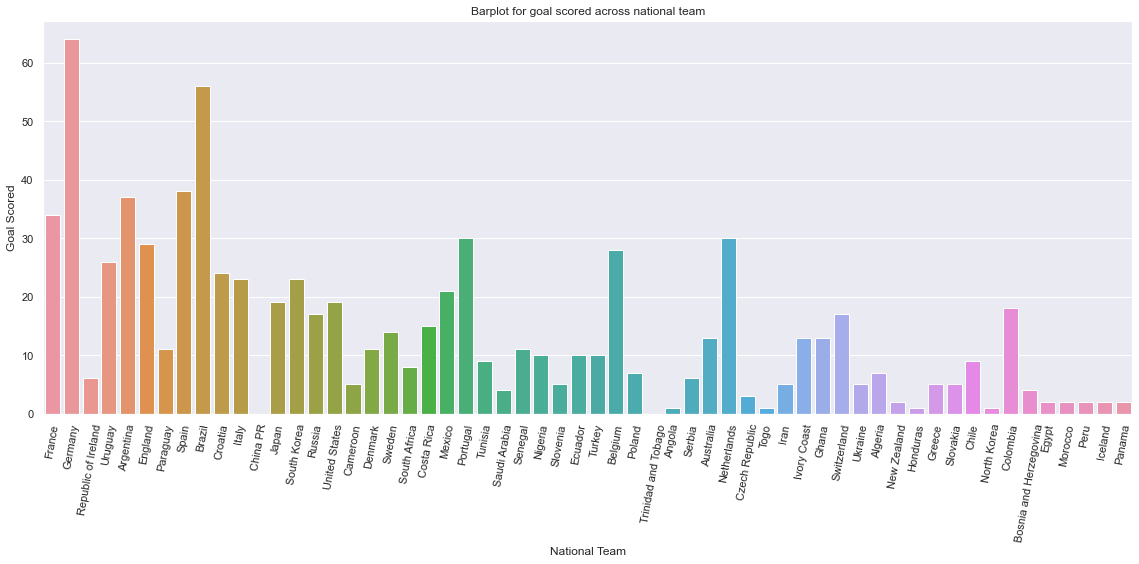

In [28]:
fig, axes = plt.subplots(figsize=(16,8))
axes = sns.barplot(data=tidy_data, x='country', y='goal_scored')
plt.xticks(rotation=80)
axes.set_title('Barplot for goal scored across national team')
axes.set_xlabel('National Team')
axes.set_ylabel('Goal Scored')
plt.tight_layout()

From the above barplot, we can see that some of the national teams suchas Germany, Argentina, Brazil, and few others have scored very higher over the years. This is a good starting point. Now that we have visualized the great attacking teams, lets display a scatter plot of the goals scored against winning percentage to check if the teams that scored the most goals have a high winning percentage (Which is what we expect because if a team goal scores the most goals then instinctively it is usual to assume that they win the most). To conform this we will do a reggression line over the scatter plot to see if there is a relationship between the goals scored and winning percentage.

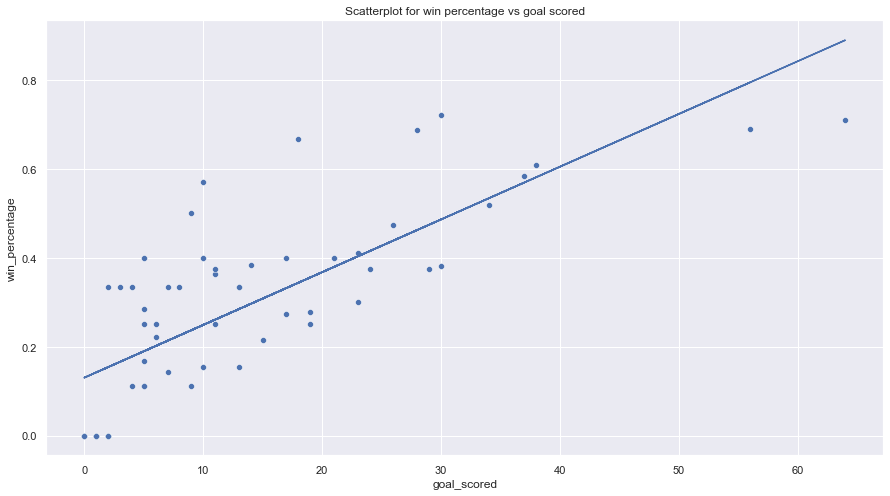

In [29]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.scatterplot(data=tidy_data, x='goal_scored',  y='win_percentage')
x= tidy_data['goal_scored']
y = tidy_data['win_percentage']
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x+b)
ax.set_title('Scatterplot for win percentage vs goal scored')
plt.show()

As we can see from the above scatter plot, there is a good relationship between goal_scored and win_percentage. The relationship between this two variables shine when the goal score is getter higher and higher. Between goal score 0 to 40, the relationship doesn't seem so great. We start seeing the effect of goal scored as the score gets higher. To check the overall relationship, we checked the correlation betwenn goal scored and win_percentage below and found approximatly a 72% relationship between the two variables, which is good overall. If you want to learn more about correlation, you can visitin this [link](https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/). 

However if what you need is to know how to do correlation in python, you can refer to [numpy-correlation](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) or [panda-correlation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)   

In [30]:
# Pearson correlation between x=goal scored and y=winning percentage
np.corrcoef(x, y)[0,1]

0.7666031170538082

Now that we checked the relationship between goal scored and winning percentage, let see the distribution of winning percentage accross all national teams. We want to do this because we would like to know which team has a higher winning percentage.Later in our analysis, we would like to narrow down the teams by taking the top ten national team, so knowing the teams who has highest winning percentage will help us to do that.

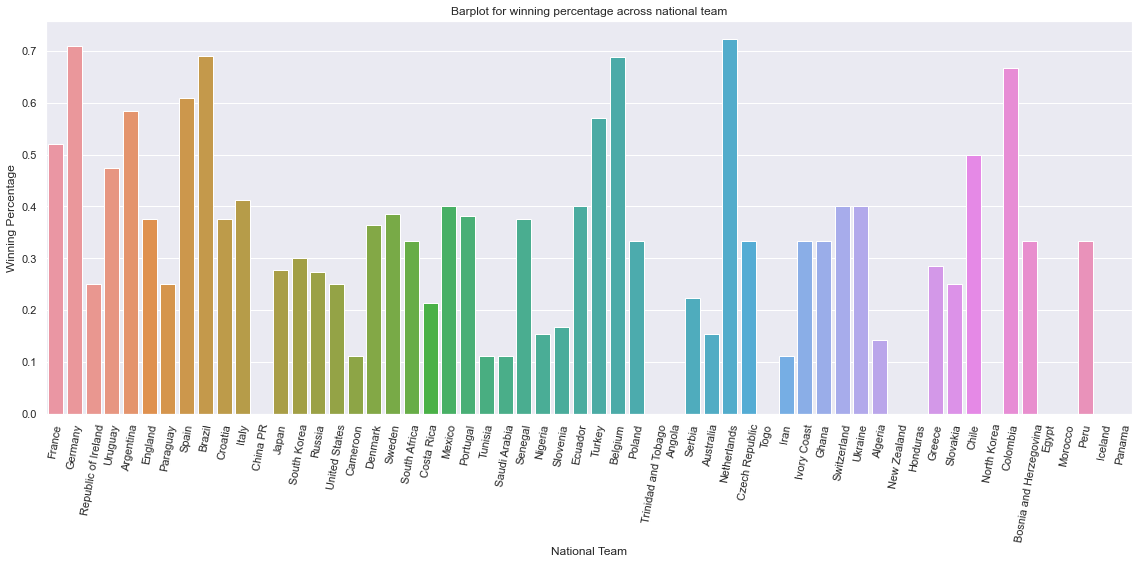

In [31]:
fig, axes = plt.subplots(figsize=(16,8))
axes = sns.barplot(data=tidy_data, x='country', y='win_percentage')
plt.xticks(rotation=80)
axes.set_title('Barplot for winning percentage across national team')
axes.set_xlabel('National Team')
axes.set_ylabel('Winning Percentage')
plt.tight_layout()

Alright, so far so good, from the above barplot, we can see that the team that scored higher(check the above two plots) have higher winning percentage. For instance Germany and Brazil had a very high goal score(126 and 120 respectivly). 
As we can see in the barplot, Brazil and Germany has higher winning percentage(Argentina, France, and Turkey has also higher winning percentage relatively). We will use this information and a couple of other metrics to take the top 10 teams, then to narrow it down further then we will apply some other metrics, such as number of times they reach world cup final, or number of times they've won the world cup, to distinguish between the top national teams.

This graphic is also pretty interesting because anyone with some football knowledge can actually start to see why this is the case. For example Brazil with one of the highest scoring numbers can be attributed to the amazing attackers they have produced in the last 2 decades for example: Neymar, Ronaldhino, Ronaldo etc.
    
In the code below, we will take the top 10 national teams by sorting based on goal_scored and win_percentage.
As we can see from the above barplot, there are teams with a very low winning percentage(some of them did not even won once). That is why we want to take the top 10 teams first. After we get the top teams, we will apply another metrics to get the best of the top 10 

In [32]:
# rank the teams based on the highest goals scored and winning percentage
top_team = tidy_data.sort_values(by=['goal_scored', 'win_percentage'], ascending=False)
# Print the first 10 rows of the dataframe
top_team = top_team.head(10)
top_team

,country,win_percentage,match_played,match_won,match_lost,goal_scored,goal_conceded,avg_goal_score_per_match
1,Germany,0.709677,31,22,9,64,22,2.064516
8,Brazil,0.689655,29,20,9,56,27,1.931034
7,Spain,0.608696,23,14,9,38,24,1.652174
4,Argentina,0.583333,24,14,10,37,24,1.541667
0,France,0.520000,25,13,12,34,19,1.360000
36,Netherlands,0.722222,18,13,5,30,12,1.666667
22,Portugal,0.380952,21,8,13,30,23,1.428571
5,England,0.375000,24,9,15,29,22,1.208333
30,Belgium,0.687500,16,11,5,28,16,1.750000
3,Uruguay,0.473684,19,9,10,26,22,1.368421


Now that we can see the top 10 teams based purely on their attacking stats i.e goals scored, why dont we do a plot just to see how many goals these teams conceed, because while having good attacking players is necessary for a team to win the world cup, it is also as vital to build this off of a solid defence.

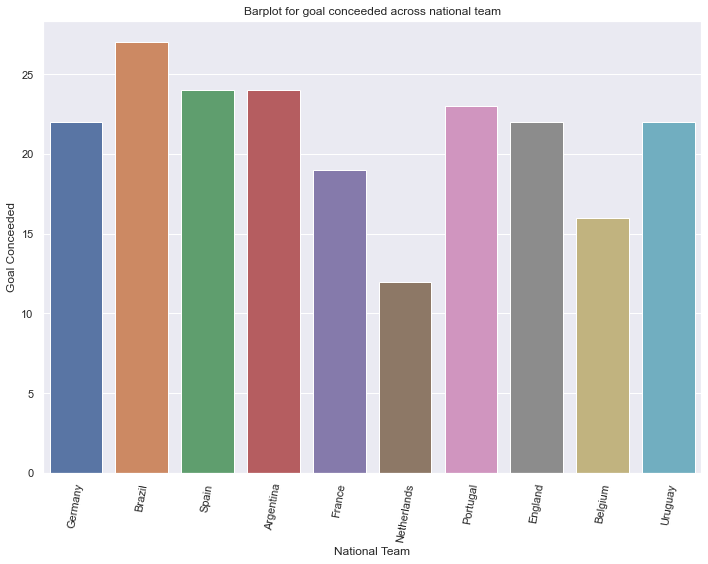

In [33]:
# Plot bar graph for goals conceeded for the top 10 teams
fig, axes = plt.subplots(figsize=(10,8))
axes = sns.barplot(data=top_team, x='country', y='goal_conceded')
plt.xticks(rotation=80)
axes.set_title('Barplot for goal conceeded across national team')
axes.set_xlabel('National Team')
axes.set_ylabel('Goal Conceeded')
plt.tight_layout()

- Now we can see that the top teams all have relatively within the same number of goals conceeded, aside from Netherlands who have conceeded the least from all of these. This is interesting because anyone with some football knowledge can actually start to see why this is the case. For example Belgium have a low goals conceeded because they had one of the best football centerback pairings Vincent Kompany and Thomas Vermaelen.

Ok. Now we sucessfully got the top 10 national teams. What we would like to do next to think of some other metric(another column) that will help us distinguish who is the best of the top 10 teams. One such metric could be the number of time each of the top 10 teams won the world cup. This is because the more time a team become a champion the better chance they have to be a better one. Our second dataset has the summary of the winners of the world cup from 1978 to 2018(last world cup). Therefore we would use it to get the number of times each national team (from the top 10) became a champion. <br>
To add a champion column, what we are going to do is take champion column from the world cup summary dataframe and as long as a national team from the top 10 teams is in the list of champions, it means it won the world cup. 
A simple way to code this is to have a dictionary with the team who won the world cup as a key and the number of time they won as a value, then we will add the value in a new column as long as the team exists among the top 10 teams  


In [34]:
# a list for the number of time a team was a champion
champ_list = []
# get the champions
champ = dict(world_cup_summary['CHAMPION'].value_counts())
for i, data  in top_team.iterrows():
    team = data['country']              # team from each row 
    if team in champ:                   # check if the team was a champion
        champ_list.append(champ[team])  # add the number of time each team was a champion to a list 
    else:                               # not a champion, so we add 0 to the list
        champ_list.append(0)
# add champions column to the top 10 teams dataframe
top_team['champion'] = champ_list
top_team

,country,win_percentage,match_played,match_won,match_lost,goal_scored,goal_conceded,avg_goal_score_per_match,champion
1,Germany,0.709677,31,22,9,64,22,2.064516,1
8,Brazil,0.689655,29,20,9,56,27,1.931034,1
7,Spain,0.608696,23,14,9,38,24,1.652174,1
4,Argentina,0.583333,24,14,10,37,24,1.541667,0
0,France,0.520000,25,13,12,34,19,1.360000,1
36,Netherlands,0.722222,18,13,5,30,12,1.666667,0
22,Portugal,0.380952,21,8,13,30,23,1.428571,0
5,England,0.375000,24,9,15,29,22,1.208333,0
30,Belgium,0.687500,16,11,5,28,16,1.750000,0
3,Uruguay,0.473684,19,9,10,26,22,1.368421,0


Becoming a champion shows that a team is good, it shows that they had the ability to get a positive result from every single opponent faced. From the above dataframe, if we see the champion column, Brazil, Germany, Spain and France were world champions once from the year 2000 to 2018 (the most recent world cup). This will help us to extract the better team from the top ten teams. 

However, as we can see above there are 4 teams who won the world cup the same number of times, so we need to use a different metric to see who would be better among the four. We could use many ways to distinguish them, one such way could be the winning percentage (a team that has a better winning percentage may be better). However, it would be better to also find teams who are better at attacking and also better at defending because if a team can do both, they are truly great, and can be considered a more complete team. <br>

**How can we do this ?** <br>
What we need to note is that if a team score a lot of goals, it means that they are very good at attacking(obviously).In the same token, if a team has a very good defense, then the goal they conced will be less. Therefore, a team who score a lot of games but concedes relativly less goals are better. This means that, we need to subtract goal conceded from goal scored and store the resut into a new column called net_goal. After we created this column, we can use it to furture narrow down the 4 teams. <br>
However, before we move on with this approach, we would like to check if there is a relationship between a team that are good at defending and attacking, and a wining percentage. To check if there is a linear relation we can fit a linear regression and see if there is a linear trend. <br>
lets add the net_goal column so tha we can use it for the linear regression. 

In [35]:
# add a net_goal column by subtracting the goal_conceded from goal_socor
net_goal = []
for i, data  in top_team.iterrows():
    score = data['goal_scored']
    concede = data['goal_conceded']
    net_goal.append(score - concede)

top_team['net_goals'] = net_goal
top_team.head()

,country,win_percentage,match_played,match_won,match_lost,goal_scored,goal_conceded,avg_goal_score_per_match,champion,net_goals
1,Germany,0.709677,31,22,9,64,22,2.064516,1,42
8,Brazil,0.689655,29,20,9,56,27,1.931034,1,29
7,Spain,0.608696,23,14,9,38,24,1.652174,1,14
4,Argentina,0.583333,24,14,10,37,24,1.541667,0,13
0,France,0.520000,25,13,12,34,19,1.360000,1,15


# Linear Regression
In this regression analysis we would like to check if we can find a linear relationship between net_goal and win_percentage. As we have tried to explain above, knowing this will help us to distinguish among the 4 best team who were a champion for the same amount of time over the past years. <br>
There are multiple ways of doing linear regression in python, we can use librarys suchas as sklearn, statsmodel or we can simply use numpy.polyfit. We will use numpy.polyfit here. However, if you would like to know how it can be done in the other two libraries, you can refer to this source [statsmodel-linear regression](https://www.statsmodels.org/stable/regression.html) or [sklearn-linear model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). If you want to know more about numpy.ployfit, you can [click here](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) to read the documentation

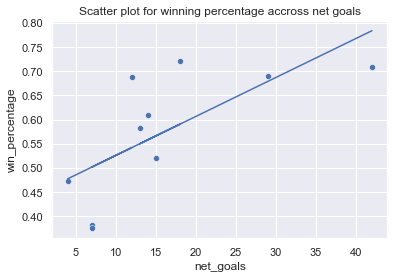

In [36]:
sns.scatterplot(data=top_team, x='net_goals',  y='win_percentage')
x= top_team['net_goals']
y = top_team['win_percentage']
plt.title('Scatter plot for winning percentage accross net goals')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()

As we can see from the scatter plot, there is a pretty good relationship between net_goals and winning percentage. As the net_goals increases, the winning persentage will also increase. This shows that if a team socred a lot of goal but only concedes less goal, then they have a higer chance of winning a game, hence higher winning percentage. As we metioned above, we have 4 teams that were a champion for the same number of time within the past years. To distinguish the among the 4 teams and find who is the best of them, we can now use their net goal(please note what the net goal signifies. Higher net goals indicate that a team is better at attacking and defensing, which will make it the best team).Lets us now extract the best natioan team that has won world cup maximum number of time and are better at attacking and defending. <br>
To do this, what we need is to get the maximum number from the champion column and the maximum number from the net goals column then use those two numbers to extract the best national team. 

In [37]:
max_champ = top_team['champion'].max()
max_net_goal = top_team['net_goals'].max()
# filter the best team based on the criteria mentioned in the prose
top_team[(top_team['champion'] == max_champ) & (top_team['net_goals'] == max_net_goal)]

,country,win_percentage,match_played,match_won,match_lost,goal_scored,goal_conceded,avg_goal_score_per_match,champion,net_goals
1,Germany,0.709677,31,22,9,64,22,2.064516,1,42


# Conclusion

Finally, we have found the country that has the greatest national team, **Brazil** <br>
Based on our analysis, ***Brazil** is the best team. After we complete our analysis and got the best team, we became curious to do a simple google search to check who is the best national team. And the first link that came up when we search *who is the best national team in the world* was [ThePowerRank.com](https://thepowerrank.com/world-football-soccer/). <br>
According to ThePowerRank, brazil is also the best national team. We don't want to be biased, so we also have looked a few other website, and brazil was among the top 3, so we are preety confident that our analysis is good. 
### What would be interesting to analysis next
It might be intersting to use similar approach to predict who would win the next world cup. It won't be easy to predict this since it involves machine learning and also requires a more indepth analysis; nonetheless, it will be a fun project to try.   
